## 1. Etiquetamos y guardamos nuestro Dataset

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
from pydub import AudioSegment
import os
import matplotlib.patches as mpatches
from Constants.DataPaths import *
from matplotlib.font_manager import FontProperties

/home/jose/src/TFG/Model/tfg/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Definimos las etiquetas, headers y rutas

In [2]:
folder_paths = [ORIGINAL_DATASET_PATH, COPY_MOVE_DATASET_PATH, SPLICING_DATASET_PATH]

# Label lists
forgery_category_label = ["Original_Audio", "Copy_Move_Audio", "Splicing_Audio"]
is_forgered_label = ["Original_Audio", "Forgered_Audio"]

# Header columns of the .csv
headers = ["audio_path", "audio_name", "is_forgered_index", "is_forgered_category", "forgery_type_index", "forgery_type_category", "duration"]

Métodos auxiliares para la asignación de etiquetas.

In [3]:
# Return the index for the forgeryCategory type and the string associated
def getForgeryType(index):
    forgery_type_index = index
    forgery_type_category = forgery_category_label[forgery_type_index]
    return forgery_type_index, forgery_type_category

# Return the index for the isForgered type and the string associated
def getIsForgered(forgery_type_index):
    is_forgered_index = (0 if forgery_type_index == 0 else 1)
    is_forgered_category = is_forgered_label[is_forgered_index]
    return is_forgered_index, is_forgered_category

# Return audio duration
def get_audio_duration(audio_file_path):
    audio = AudioSegment.from_file(audio_file_path)
    return round(len(audio) / 1000)  # Duration in seconds

# Write the row to the file labeled_dataset.csv
def write(writer, file_path, file_name, is_forgered_index, is_forgered_category, forgery_type_index, forgery_type_category, duration):
    writer.writerow([
        file_path,
        file_name, 
        is_forgered_index, 
        is_forgered_category, 
        forgery_type_index, 
        forgery_type_category,
        duration
    ])
          

Escribimos nuestro CSV.

In [4]:
# Load paths of the audios from my dataset
with open(LABELS_DATASET_PATH, 'w', newline='') as csvfile:
    # Write headers in the csv file
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(i for i in headers)
    
    # Travel through all folders of the dataset
    for index, folder in enumerate(folder_paths):        
        for root, dirs, files in os.walk(folder):

            # Travel through all the files in each folder
            for file in files:
                if file.endswith(".WAV"):
                    file_path = os.path.join(root, file)
                    file_name, _ = os.path.splitext(file)

                    forgery_type_index, forgery_type_category = getForgeryType(index)
                    is_forgered_index, is_forgered_category = getIsForgered(forgery_type_index)
                    
                    duration = get_audio_duration(file_path)
                    
                    write(writer, file_path, file_name, is_forgered_index, is_forgered_category, forgery_type_index, forgery_type_category, duration)
                

Cargamos el dataset en un dataframe.

In [5]:
# Load the data from CSV to a Dataframe
df = pd.read_csv(LABELS_DATASET_PATH)

## 2. Tamaño del Dataset

Colores para graficar nuestro tamaño de datos

In [6]:
# Define colors for the plots
colors_forgery = ['orange', 'green', 'lightblue']
colors_is_forgered = ['lightgreen', 'purple']

#### 2.1. Gráfica para ``forgery_category_label``

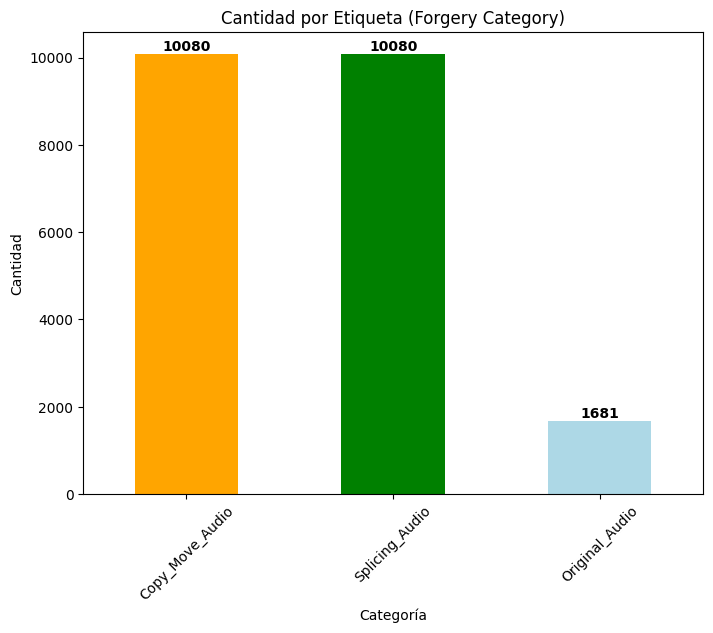

In [7]:
# Plot for the forgery_category_label
plt.figure(figsize=(8, 6))
forgery_counts = df['forgery_type_category'].value_counts()
forgery_counts.plot(kind='bar', color=colors_forgery)

# Añadimos el número exacto de muestras
for i, count in enumerate(forgery_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontweight='bold')

plt.title('Cantidad por Etiqueta (Forgery Category)')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

#### 2.1. Gráfica para ``is_forgered_category``

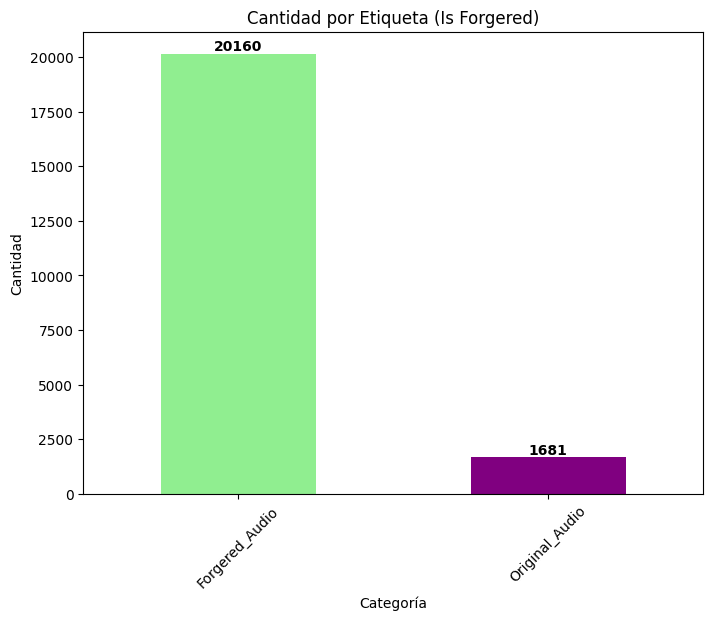

In [8]:
# Plot for the is_forgered_label
plt.figure(figsize=(8, 6))
is_forgered_counts = df['is_forgered_category'].value_counts()
is_forgered_counts.plot(kind='bar', color=colors_is_forgered)

# Añadimos el número exacto de muestras
for i, count in enumerate(is_forgered_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontweight='bold')

plt.title('Cantidad por Etiqueta (Is Forgered)')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

## 3. Duraciones de los audios.

In [9]:
# Get the number of audios for each duration group
duration_counts = df['duration'].value_counts().sort_index()


# Colors for each section of the plot
colors = (['tab:orange', 'tab:purple', 'tab:green', 'tab:red', 'tab:blue', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
colors.extend(['xkcd:baby poop green', 'xkcd:blood orange', 'xkcd:dark pastel green', 'xkcd:dusty purple'])
colors.extend(['gold', 'lime', 'tomato', 'turquoise', 'violet', 'wheat', 'yellowgreen'])



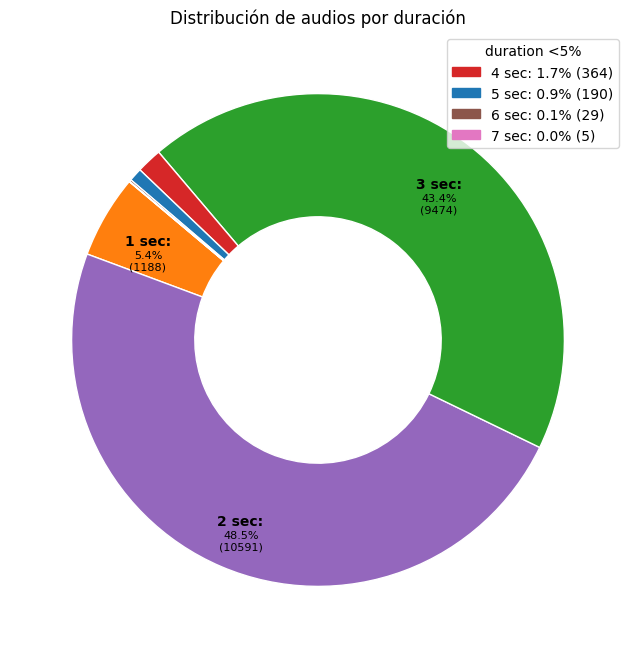

In [10]:
# Find the bigger section
max_percentage_section = duration_counts.idxmax()

# Create the donut chart
plt.figure(figsize=(8, 8))
pie = plt.pie(
    duration_counts,
    colors=colors, 
    startangle=140,
    wedgeprops=dict(width=0.5, edgecolor='white'))

# Add annotations
threshold = 5
legend_labels = []
legend_handles = []
total = sum(duration_counts)

# Include the text
for i, (percentage, label) in enumerate(zip(duration_counts / total * 100, duration_counts.index)):
    if percentage < threshold:
        # Append values for the legend
        legend_labels.append(f'{label} sec: {percentage:.1f}% ({duration_counts[label]})')
        # Add colors
        legend_handles.append(mpatches.Patch(color=colors[i], label=f'{label}:'))
        continue

    # Calculate angle for annotation position
    angle = (pie[0][i].theta2 - pie[0][i].theta1) / 2 + pie[0][i].theta1

    # Calculate coordinates for annotation position
    x = 0.8 * pie[0][i].r * np.cos(np.deg2rad(angle))
    y = 0.8 * pie[0][i].r * np.sin(np.deg2rad(angle))
    
    # Add annotation at the center of the section
    plt.text(x, y, f'{label} sec:', ha='center', va='center', fontweight= 'bold')
    plt.text(x+0.001, y-0.08, f'{percentage:.1f}%\n({duration_counts[label]})', ha='center', va='center', fontsize=8)

# Add legend for annotations below threshold
plt.legend(handles=legend_handles, labels=legend_labels, loc='upper right', title="duration <5%")

# Add title
plt.title('Distribución de audios por duración')

plt.show()

